In [1]:
# working on the dynamic triggering ideas on one event and one station from west Texas
# authors - Kaushik Pradhan (kpradhan@miners.utep.edu)
# last updated - 02/26/2024

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import os
import sys
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from mpl_toolkits.basemap import Basemap
import seaborn as sns

from obspy.signal import PPSD
from obspy.imaging.cm import pqlx
from obspy.signal.trigger import classic_sta_lta
from scipy.stats import poisson

In [3]:
# read the csv file from a link - magnitude Mw 6.5+ earthquakes from 2017 to today
usgs_6_5_plus = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2017-01-01%2000:00:00&endtime=2024-02-19%2023:59:59&minmagnitude=6.5&eventtype=earthquake&orderby=time'
data_usgs_6_5_plus = pd.read_csv(usgs_6_5_plus)

URLError: <urlopen error [Errno 61] Connection refused>

In [ ]:
data_usgs_6_5_plus.head()

time  latitude  longitude    depth  mag magType    nst  \
0  2024-01-28T09:38:56.538Z   -8.2360   -71.4005  621.081  6.5     mww  237.0   
1  2024-01-22T18:09:04.418Z   41.2628    78.6594   13.000  7.0     mww  121.0   
2  2024-01-20T21:31:05.092Z   -7.2879   -71.4640  607.000  6.6     mww  185.0   
3  2024-01-08T20:48:42.361Z    4.9225   126.1575   62.574  6.7     mww  138.0   
4  2024-01-01T07:10:09.478Z   37.4877   137.2711   10.000  7.5     mww  282.0   

    gap   dmin   rms  ...                   updated  \
0  40.0  6.527  0.86  ...  2024-02-22T17:16:46.433Z   
1  29.0  0.425  0.65  ...  2024-03-04T20:58:33.040Z   
2  36.0  7.065  0.69  ...  2024-01-28T03:50:35.966Z   
3  22.0  2.209  0.76  ...  2024-02-15T13:58:52.710Z   
4  36.0  0.956  0.55  ...  2024-03-04T12:12:35.010Z   

                                   place        type horizontalError  \
0            70 km W of Tarauacá, Brazil  earthquake            7.28   
1             128 km WNW of Aykol, China  earthquake            4.69   
2          123 km NW of Tarauacá, Brazil  earthquake            9.42   
3     93 km SE of Sarangani, Philippines  earthquake            7.15   
4  2024 Noto Peninsula, Japan Earthquake  earthquake            4.01   

  depthError  magError  magNst    status  locationSource magSource  
0      2.996     0.062    25.0  reviewed              us        us  
1      1.811     0.054    33.0  reviewed              us        us  
2      1.919     0.073    18.0  reviewed              us        us  
3      3.404     0.060    27.0  reviewed              us        us  
4      1.807     0.034    82.0  reviewed              us        us  

[5 rows x 22 columns]

AttributeError: Rectangle.set() got an unexpected keyword argument 'nbins'

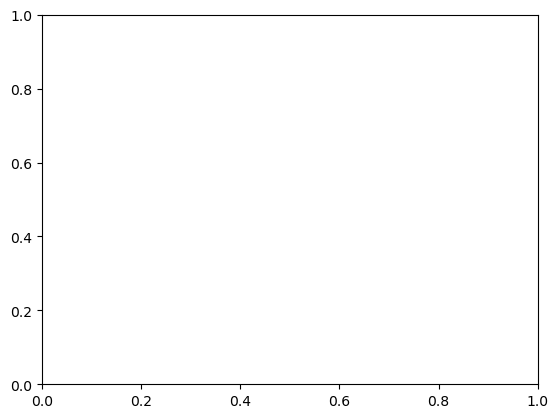

In [ ]:
#plotting the histogram of the magnitudes

magnitudes = data_usgs_6_5_plus['mag']
sns.histplot(magnitudes, kde=False, nbins=20)
sns.kdeplot(magnitudes) #best fit line

# vertical axis log
plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Magnitude Distribution of Mw 6.5 + Global Earthquakes - 2017 to 2024')
plt.ylim(1, 200)
plt.show()

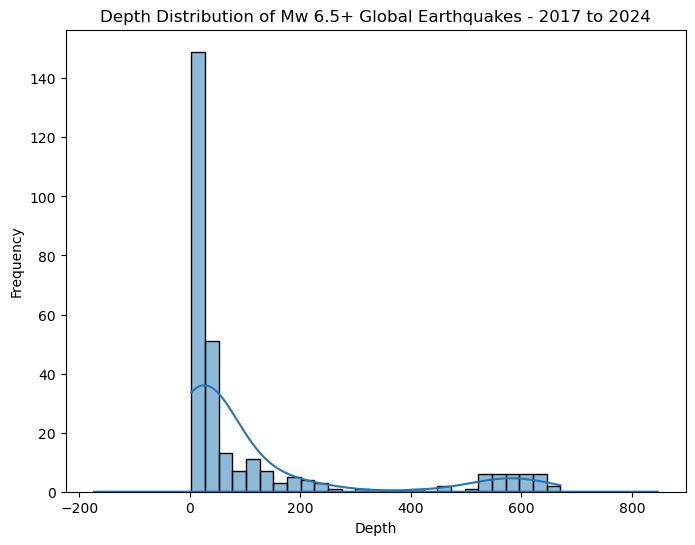

In [ ]:
depths = data_usgs_6_5_plus['depth']

plt.figure(figsize=(8, 6))

# Plotting depth distribution
sns.histplot(depths, kde=True)
sns.kdeplot(depths) #best fit line
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Depth Distribution of Mw 6.5+ Global Earthquakes - 2017 to 2024')

plt.show()

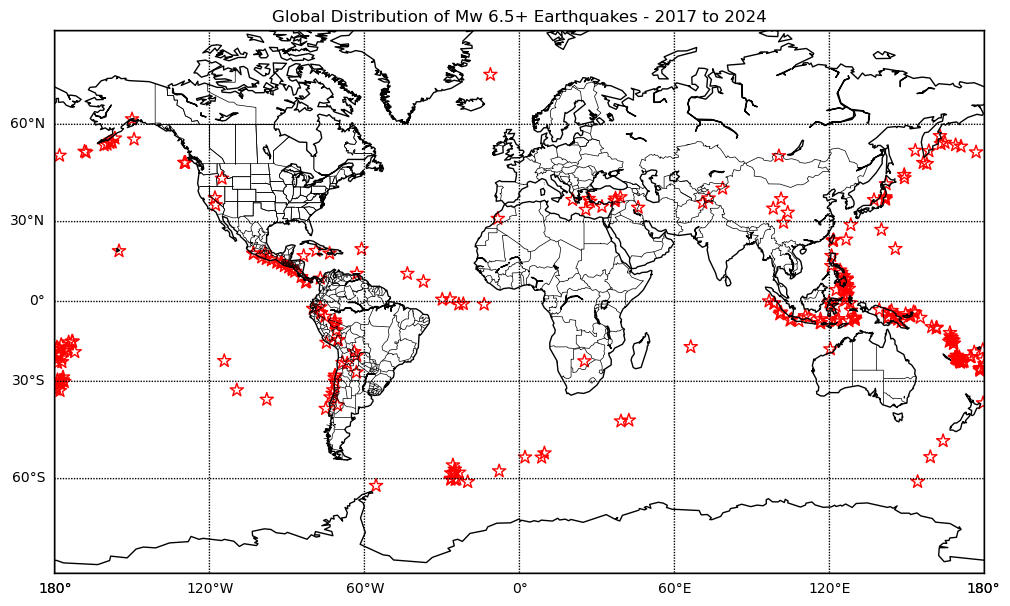

In [ ]:
fig = plt.figure(figsize=(12, 10))
m = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='none')  # remove fill color on map boundary
m.fillcontinents(color='none', lake_color='none')  # remove fill color on continents

m.drawparallels(np.arange(-90, 91, 30), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180, 181, 60), labels=[0, 0, 0, 1])

lons = data_usgs_6_5_plus['longitude'].values
lats = data_usgs_6_5_plus['latitude'].values
x, y = m(lons, lats)
m.scatter(x, y, marker='*', color='none', edgecolors='r', s=100)

plt.title('Global Distribution of Mw 6.5+ Earthquakes - 2017 to 2024')
plt.show()

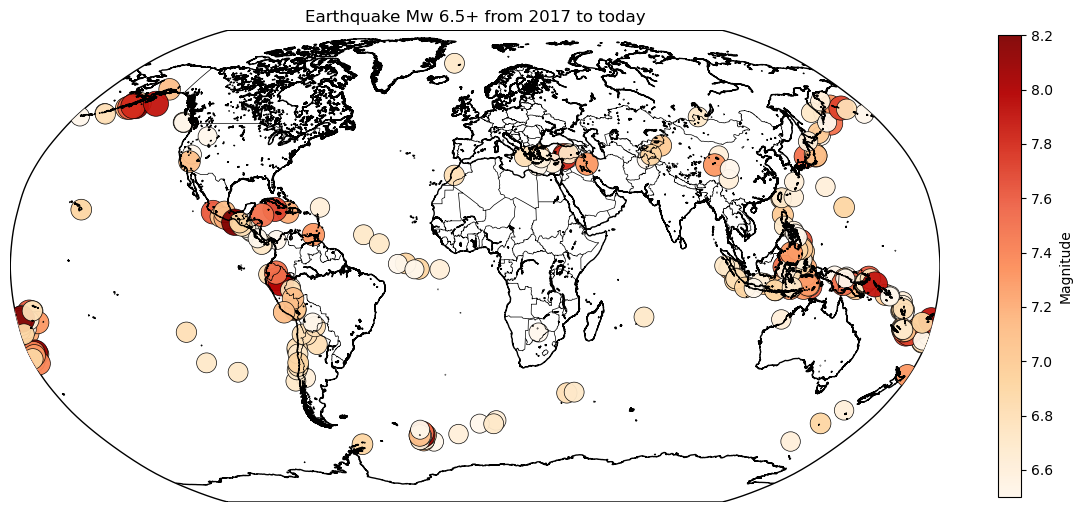

In [ ]:
plt.figure(figsize=(15, 12))
map = Basemap(projection='robin', resolution='i', lat_0=0, lon_0=0)

map.drawcoastlines()
map.drawcountries()

x, y = map(data_usgs_6_5_plus['longitude'], data_usgs_6_5_plus['latitude'])
sc = map.scatter(x, y, s=data_usgs_6_5_plus['mag']**2.8, c=data_usgs_6_5_plus['mag'], cmap='OrRd', alpha=0.95, edgecolors='k', linewidth=0.5)

plt.title('Earthquake Mw 6.5+ from 2017 to today')

cbar = plt.colorbar(sc, shrink=0.5)
cbar.set_label('Magnitude')

plt.show()

In [ ]:
#plot the distribution of stations in texnet
texnet_stns =  pd.read_csv('texnet_stations.csv')
texnet_stns.head()

Network Code Station Code  Longitude (WGS84)  Latitude (WGS84)  \
0           US         KVTX           -97.8929           27.5459   
1           US          JCT           -99.8022           30.4794   
2           US         NATX           -94.6610           31.7598   
3           US         MNTX          -105.3821           31.6985   
4           US         MIAR           -93.5765           34.5454   

                              Affiliation Archive  Location Description  \
0  United States National Seismic Network   TXHUB                   NaN   
1  United States National Seismic Network   TXHUB                   NaN   
2  United States National Seismic Network   TXHUB                   NaN   
3  United States National Seismic Network   TXHUB                   NaN   
4  United States National Seismic Network   TXHUB                   NaN   

                Place  Elevation  Start Date End Date  
0          Kingsville       14.6  2006-06-15      NaN  
1            Junction      591.0  2000-02-02      NaN  
2         Nacogdoches      168.0  2004-05-11      NaN  
3  Cornudas Mountains      404.8  2003-05-28      NaN  
4           Mount Ida      207.0  1992-09-22      NaN

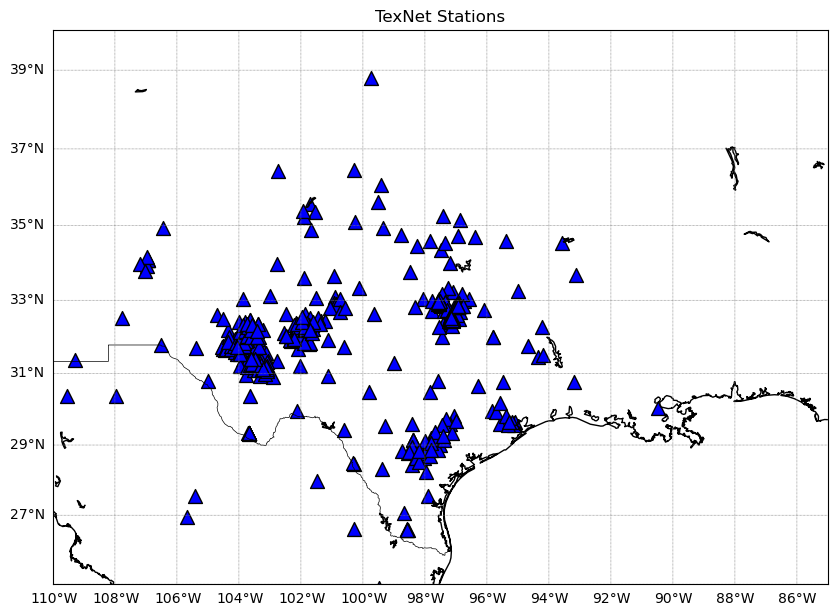

In [ ]:
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=25, urcrnrlat=40, llcrnrlon=-110, urcrnrlon=-85, resolution='i')
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(25, 41, 2), labels=[1, 0, 0, 0], linewidth=0.5, color='gray')
m.drawmeridians(np.arange(-110, -84, 2), labels=[0, 0, 0, 1], linewidth=0.5, color='gray')

lons = texnet_stns['Longitude (WGS84)'].values
lats = texnet_stns['Latitude (WGS84)'].values
x, y = m(lons, lats)
m.scatter(x, y, marker='^', color='b', edgecolors='k', linewidths=1, s=100)

plt.title('TexNet Stations')
plt.show()

In [ ]:
# plot the local events in the region - west Texas
tex_net_events = pd.read_csv('texnet_events.csv')
tex_net_events.head()

EventID Evaluation Status Origin Date Origin Time  Local Magnitude  \
0  texnet2024dikg             final  2024-02-17    06:52:16              3.3   
1  texnet2024dijs             final  2024-02-17    06:34:18              3.7   
2  texnet2024dijp             final  2024-02-17    06:32:54              4.7   
3  texnet2024dijf             final  2024-02-17    06:20:21              4.4   
4  texnet2024diek         Automatic  2024-02-17    03:53:14              1.5   

   Moment Magnitude  Latitude (WGS84)  Latitude Error (km)  Longitude (WGS84)  \
0               NaN           28.9719                  1.0           -97.9650   
1               NaN           28.9627                  1.7           -97.9360   
2               NaN           28.9581                  0.6           -98.0053   
3               NaN           28.9545                  0.5           -98.0053   
4               NaN           31.6708                  1.5          -104.4363   

   Longitude Error (km)  ...  Nodal Plane 1 - Rake  Nodal Plane 2 - Strike  \
0                   0.9  ...                   NaN                     NaN   
1                   1.1  ...                   NaN                     NaN   
2                   0.6  ...                   NaN                     NaN   
3                   0.5  ...                   NaN                     NaN   
4                   1.4  ...                   NaN                     NaN   

   Nodal Plane 2 - Dip  Nodal Plane 2 - Rake  Focal Mechanism Method ID  \
0                  NaN                   NaN                        NaN   
1                  NaN                   NaN                        NaN   
2                  NaN                   NaN                        NaN   
3                  NaN                   NaN                        NaN   
4                  NaN                   NaN                        NaN   

   Focal Mechanism - Azimuthal Gap Focal Mechanism - Misfit  \
0                              NaN                      NaN   
1                              NaN                      NaN   
2                              NaN                      NaN   
3                              NaN                      NaN   
4                              NaN                      NaN   

  Maximum Station Distance (km) Minimum Station Distance (km)  \
0                     59.292870                      6.755903   
1                     57.994875                      4.425812   
2                     55.083000                      2.722672   
3                     51.689021                      2.563408   
4                    111.074852                      1.672291   

          Last Updated  
0  2024-02-19 17:26:46  
1  2024-02-19 17:25:56  
2  2024-02-19 17:22:46  
3  2024-02-19 17:24:48  
4  2024-02-17 04:33:21  

[5 rows x 31 columns]

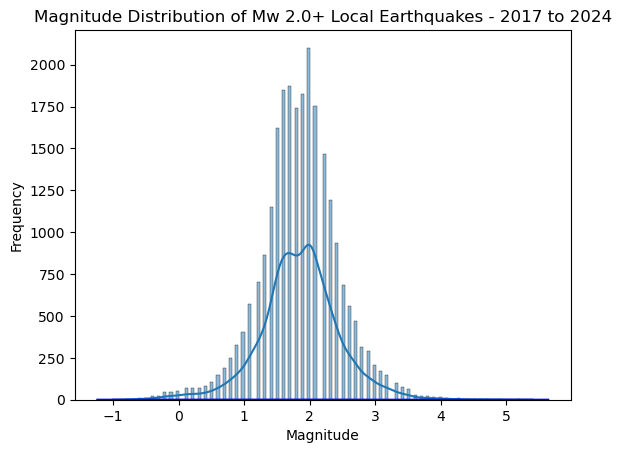

In [ ]:
magnitudes = tex_net_events['Local Magnitude']
sns.histplot(magnitudes, kde=True)
sns.kdeplot(magnitudes, color='blue') #best fit line

plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Magnitude Distribution of Mw 2.0+ Local Earthquakes - 2017 to 2024')

plt.show()

/var/folders/3g/ljxx_82d39d9sy9wrtthx3pr0000gp/T/ipykernel_19538/553080181.py:22: RuntimeWarning: divide by zero encountered in log10
  log_magnitudes = np.log10(sorted_magnitudes)
/var/folders/3g/ljxx_82d39d9sy9wrtthx3pr0000gp/T/ipykernel_19538/553080181.py:22: RuntimeWarning: invalid value encountered in log10
  log_magnitudes = np.log10(sorted_magnitudes)


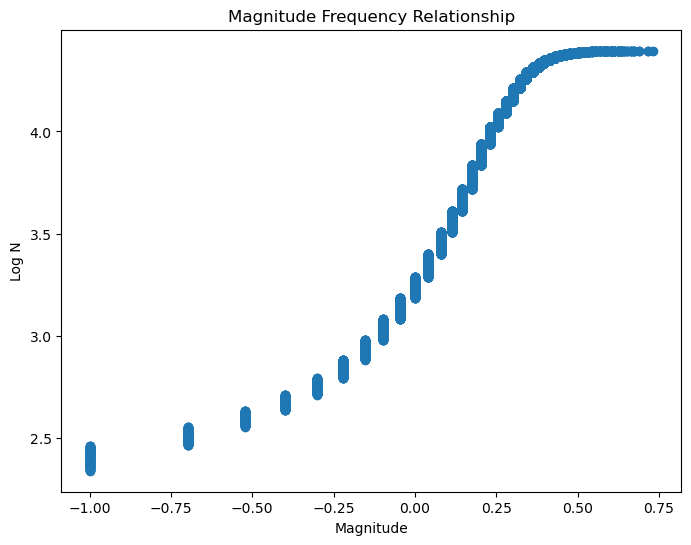

In [ ]:
'''The b value estimated by fitting a set of observed earthquake magnitudes to the magnitude-frequency relationship, 
log N(m) = a - bm, where N(m) = number of earthquakes exceeding magnitude m, is correlated with the fitting technique used.
Link - https://pubs.geoscienceworld.org/ssa/bssa/article-abstract/73/3/831/118402/Maximum-likelihood-estimation-of-b-values-for#'''

# see the magnitude frequency relationship
magnitudes = tex_net_events['Local Magnitude']
magnitudes = magnitudes.values

# sort the magnitudes
sorted_magnitudes = np.sort(magnitudes)

# calculate the number of events
n = len(magnitudes)

# calculate the cumulative number of events
N = np.arange(1, n+1)

# calculate the log of the cumulative number of events
log_N = np.log10(N)

# calculate the log of the magnitudes
log_magnitudes = np.log10(sorted_magnitudes)

# plot the magnitude frequency relationship
plt.figure(figsize=(8, 6))
plt.plot(log_magnitudes, log_N, 'o')
plt.xlabel('Magnitude')
plt.ylabel('Log N')
plt.title('Magnitude Frequency Relationship')
plt.show()

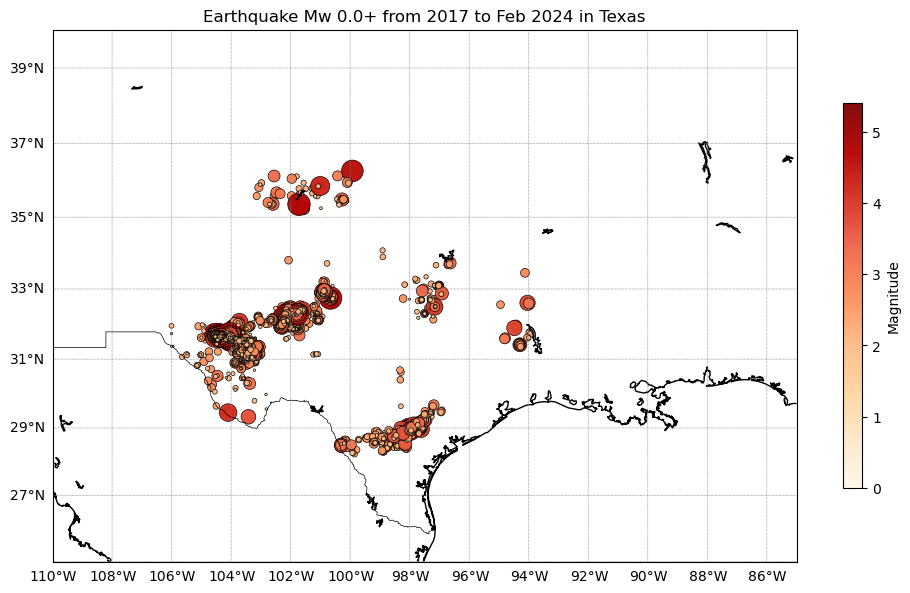

In [ ]:
# plot the events on the map
plt.figure(figsize=(12, 10))
map = Basemap(projection='merc', llcrnrlat=25, urcrnrlat=40, llcrnrlon=-110, urcrnrlon=-85, resolution='i')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(25, 41, 2), labels=[1, 0, 0, 0], linewidth=0.5, color='gray')
map.drawmeridians(np.arange(-110, -84, 2), labels=[0, 0, 0, 1], linewidth=0.5, color='gray')

x, y = map(tex_net_events['Longitude (WGS84)'], tex_net_events['Latitude (WGS84)'])
sc = map.scatter(x, y, s=tex_net_events['Local Magnitude']**3.6, c=tex_net_events['Local Magnitude'], cmap='OrRd', alpha=0.95, edgecolors='k', linewidth=0.5)

plt.title('Earthquake Mw 0.0+ from 2017 to Feb 2024 in Texas')

cbar = plt.colorbar(sc, shrink=0.5)
cbar.set_label('Magnitude')

plt.show()


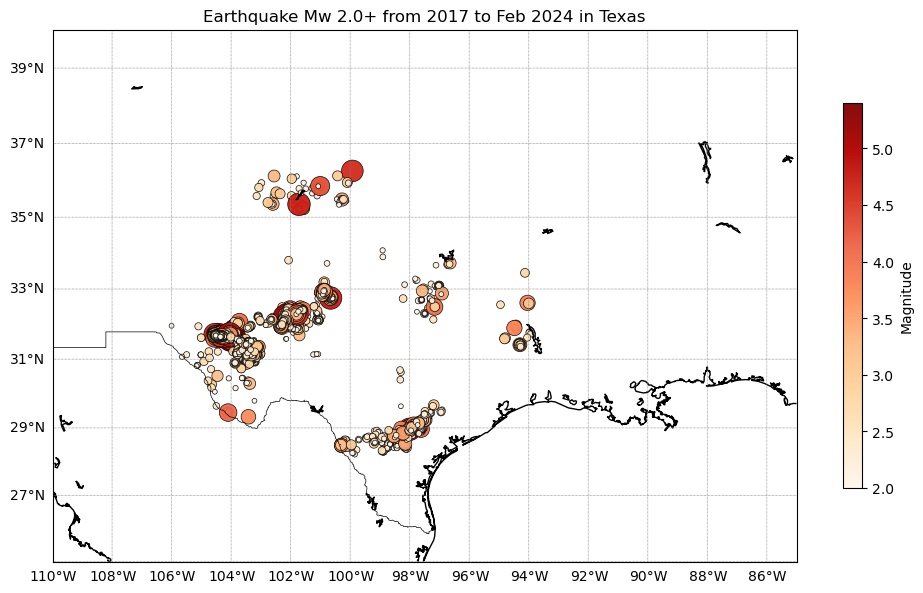

In [ ]:
# Filter the events with magnitude >= 2.0
filtered_events = tex_net_events[tex_net_events['Local Magnitude'] >= 2.0]

# Plot the filtered events on the map
plt.figure(figsize=(12, 10))
map = Basemap(projection='merc', llcrnrlat=25, urcrnrlat=40, llcrnrlon=-110, urcrnrlon=-85, resolution='i')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(25, 41, 2), labels=[1, 0, 0, 0], linewidth=0.5, color='gray')
map.drawmeridians(np.arange(-110, -84, 2), labels=[0, 0, 0, 1], linewidth=0.5, color='gray')

x, y = map(filtered_events['Longitude (WGS84)'], filtered_events['Latitude (WGS84)'])
sc = map.scatter(x, y, s=filtered_events['Local Magnitude']**3.6, c=filtered_events['Local Magnitude'], cmap='OrRd', alpha=0.95, edgecolors='k', linewidth=0.5)

plt.title('Earthquake Mw 2.0+ from 2017 to Feb 2024 in Texas')

cbar = plt.colorbar(sc, shrink=0.5)
cbar.set_label('Magnitude')

plt.show()

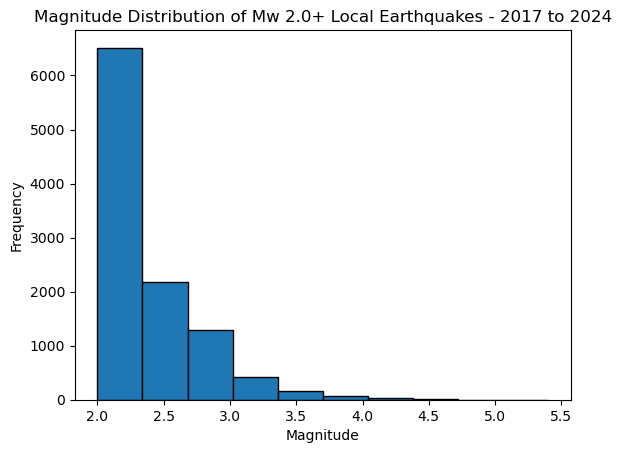

In [ ]:
# plot the magnitude histogram on filtered events
magnitudes = filtered_events['Local Magnitude']
plt.hist(magnitudes, edgecolor='black')

plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Magnitude Distribution of Mw 2.0+ Local Earthquakes - 2017 to 2024')
plt.show()

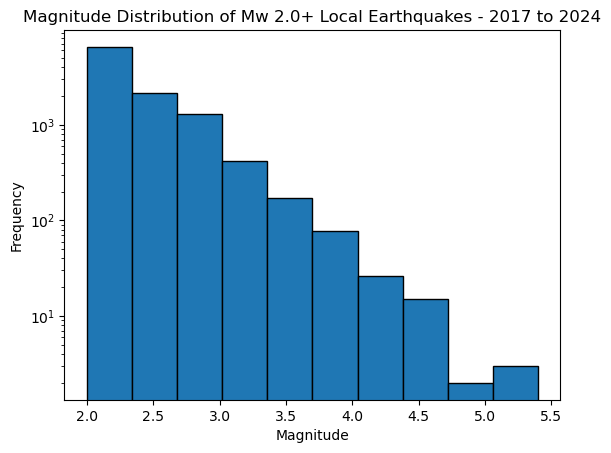

In [ ]:
# plot the magnitude histogram on filtered events - ylog scale
magnitudes = filtered_events['Local Magnitude']
plt.hist(magnitudes,edgecolor='black')

plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Magnitude Distribution of Mw 2.0+ Local Earthquakes - 2017 to 2024')
plt.show()

In [ ]:
#take one event from USGS catalog and one station from texnet and see the data

big_eq_event = data_usgs_6_5_plus.loc[data_usgs_6_5_plus['mag'].idxmax()] #highest magnitude event
print(big_eq_event)

# select one station from texnet
tx_station = texnet_stns[(texnet_stns['Latitude (WGS84)'] >= 25) & (texnet_stns['Latitude (WGS84)'] <= 36) & (texnet_stns['Longitude (WGS84)'] >= -106) & (texnet_stns['Longitude (WGS84)'] <= -93)].sample(1)
print(tx_station)

time               2021-07-29T06:15:49.188Z
latitude                            55.3635
longitude                         -157.8876
depth                                  35.0
mag                                     8.2
magType                                 mww
nst                                     NaN
gap                                     NaN
dmin                                    NaN
rms                                    0.95
net                                      ak
id                             ak0219neiszm
updated            2023-12-14T21:10:33.659Z
place                      Alaska Peninsula
type                             earthquake
horizontalError                         NaN
depthError                              0.0
magError                                NaN
magNst                                  NaN
status                             reviewed
locationSource                           ak
magSource                                ak
Name: 121, dtype: object
    Net

/Users/kaushikpradhan/anaconda3/lib/python3.10/site-packages/mpl_toolkits/basemap/__init__.py:552: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)
/Users/kaushikpradhan/anaconda3/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


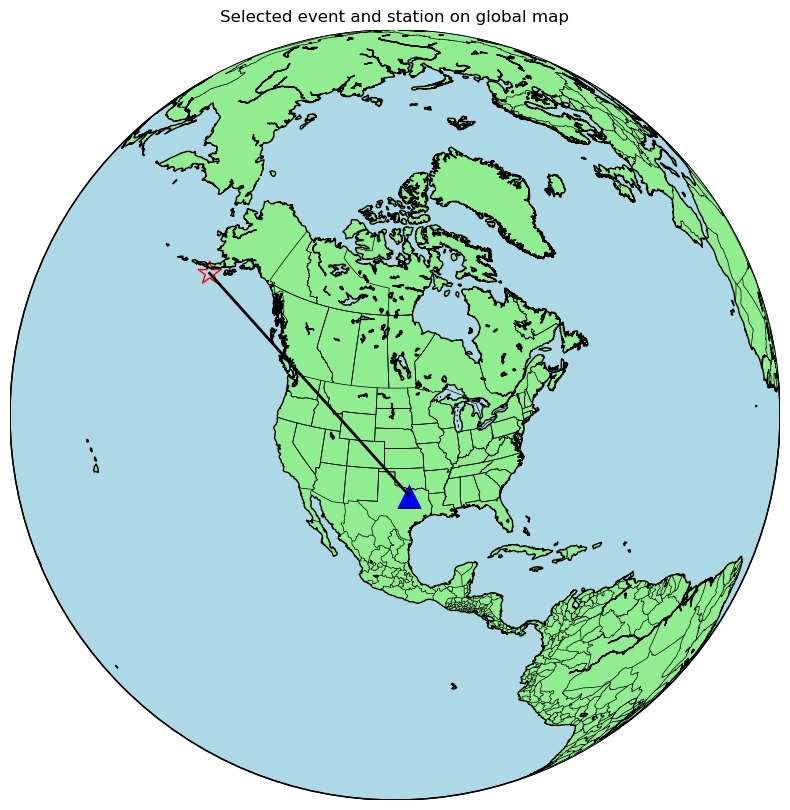

In [ ]:
fig = plt.figure(figsize=(12, 10))
m = Basemap(projection='ortho', lat_0=45, lon_0=-100, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='lightblue')  # color the ocean
m.fillcontinents(color='lightgreen', lake_color='lightblue')  # color the land

x, y = m(big_eq_event['longitude'], big_eq_event['latitude'])
m.scatter(x, y, marker='*', color='none', edgecolors='r', s=300)

x, y = m(tx_station['Longitude (WGS84)'], tx_station['Latitude (WGS84)'])
m.scatter(x, y, marker='^', color='b', edgecolors='k', linewidths=0.1, s=300)

# Draw a line between the event and station
x_event, y_event = m(big_eq_event['longitude'], big_eq_event['latitude'])
x_station, y_station = m(tx_station['Longitude (WGS84)'], tx_station['Latitude (WGS84)'])
m.plot([x_event, x_station], [y_event, y_station], color='black', linewidth=2.0)

plt.title('Selected event and station on global map')
plt.show()

/Users/kaushikpradhan/anaconda3/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)


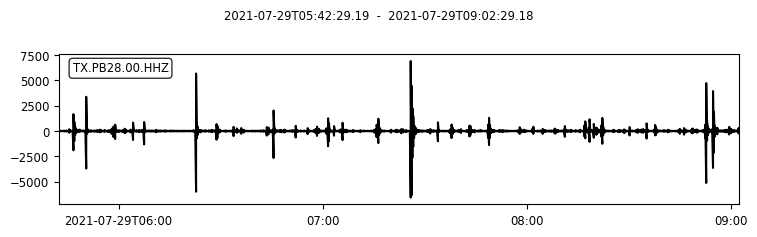

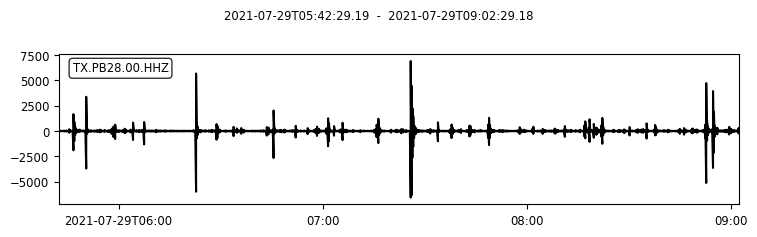

In [ ]:
#get the waveform recorded at the station
client = Client('IRIS')
event_time = UTCDateTime(big_eq_event['time'])
start_time = event_time - 2000
end_time = event_time + 10000
st = client.get_waveforms('TX', 'PB28', '*', 'HHZ', start_time, end_time)
st.detrend('constant')  # remove mean from the signal

st.filter('bandpass', freqmin=5.0, freqmax=50.0)

st.plot()

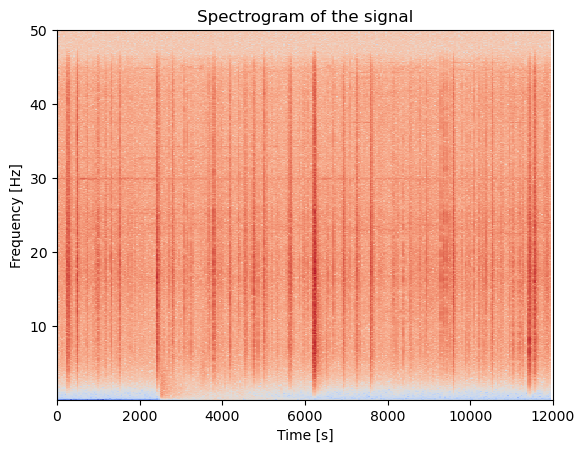

[None]

In [ ]:
# plot the spectrogram
st.spectrogram(log=False, title='Spectrogram of the signal', dbscale=True, wlen=100, per_lap=0.5, cmap='coolwarm')

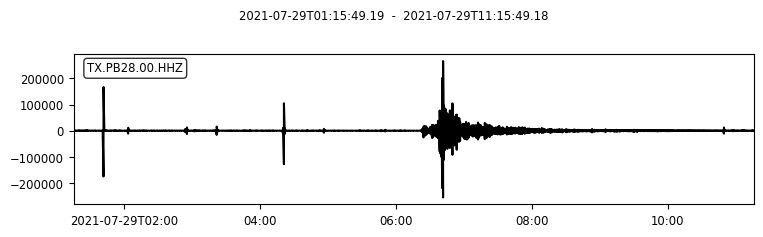

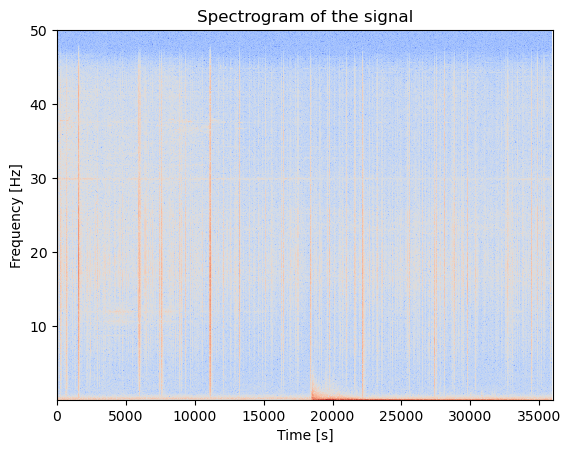

[None]

In [ ]:
# requesting data from the station - 5 hours before and after the event

start_time = event_time - 5 * 3600  
end_time = event_time + 5 * 3600  

st = client.get_waveforms('TX', 'PB28', '*', 'HHZ', start_time, end_time)

st.detrend('linear')
st.detrend('demean')

#st.filter('highpass', freq=5.0)

st.plot()

#also plot the spectrogram
st.spectrogram(log=False, title='Spectrogram of the signal', dbscale=True, wlen=100, per_lap=0.5, cmap='coolwarm')

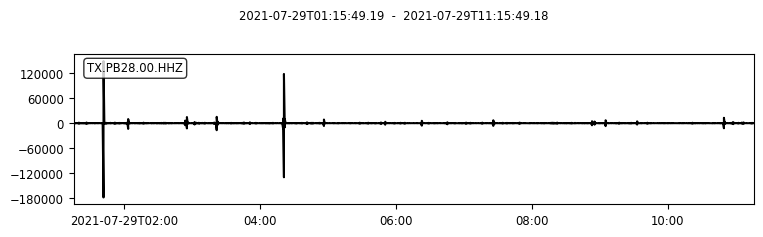

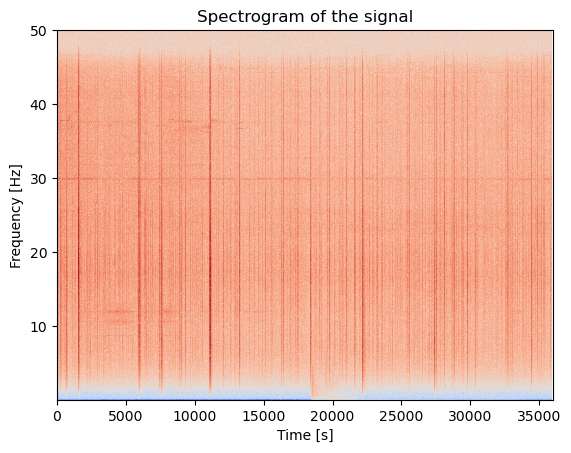

[None]

In [ ]:
# apply high pass filter and plot the data

st.filter('highpass', freq=5.0)

st.plot()

st.spectrogram(log=False, title='Spectrogram of the signal', dbscale=True, wlen=100, per_lap=0.5, cmap='coolwarm')


In [ ]:
# look at the noise characteristics of the station to see if it is suitable for the analysis
start_time = event_time - 12 * 3600
end_time = event_time + 12 * 3600
noise_data = client.get_waveforms('TX', 'PB28', '*', 'HHZ', start_time, end_time)

noise_data.detrend('linear')
noise_data.detrend('demean')

1 Trace(s) in Stream:
TX.PB28.00.HHZ | 2021-07-28T18:15:49.190000Z - 2021-07-29T18:15:49.180000Z | 100.0 Hz, 8640000 samples

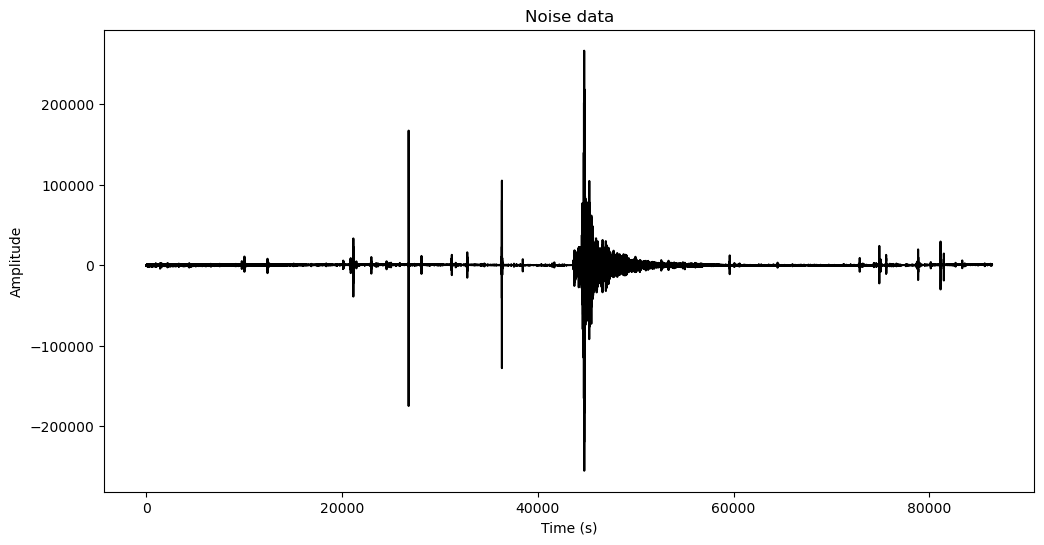

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(noise_data[0].times(), noise_data[0].data, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noise data')
plt.show()

In [ ]:
# let's look at the number of events in the texnet catalog 5 hours before and 5 hours after the event
start_time = event_time - 5 * 3600
end_time = event_time + 5 * 3600

#get a subset of the filtered_events where date Origin Date and	Origin Time is between start_time and end_time

#combine origin date and time first and then convert to datetime
filtered_events['Origin Date Time'] = pd.to_datetime(filtered_events['Origin Date'] + ' ' + filtered_events['Origin Time'])

#comvert Origin Date Time to UTCDateTime
filtered_events['Origin Date Time'] = filtered_events['Origin Date Time'].apply(lambda x: UTCDateTime(x))

#filter the events
events_subset = filtered_events[(filtered_events['Origin Date Time'] >= start_time) & (filtered_events['Origin Date Time'] <= end_time)]

len(events_subset)

/var/folders/3g/ljxx_82d39d9sy9wrtthx3pr0000gp/T/ipykernel_44236/1179287243.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events['Origin Date Time'] = pd.to_datetime(filtered_events['Origin Date'] + ' ' + filtered_events['Origin Time'])
/var/folders/3g/ljxx_82d39d9sy9wrtthx3pr0000gp/T/ipykernel_44236/1179287243.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events['Origin Date Time'] = filtered_events['Origin Date Time'].apply(lambda x: UTCDateTime(x))


5

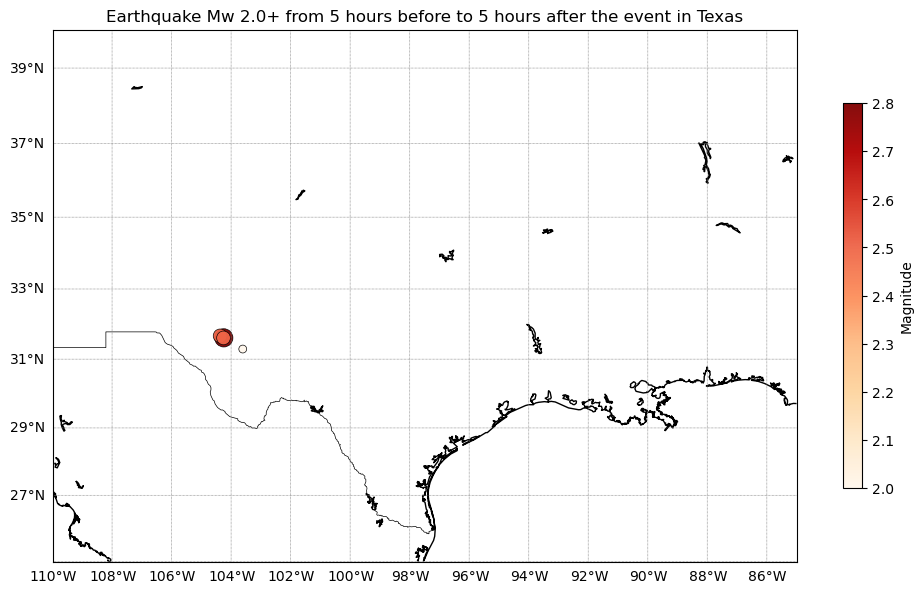

In [ ]:
# plot the event subset locations
plt.figure(figsize=(12, 10))
map = Basemap(projection='merc', llcrnrlat=25, urcrnrlat=40, llcrnrlon=-110, urcrnrlon=-85, resolution='i')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(25, 41, 2), labels=[1, 0, 0, 0], linewidth=0.5, color='gray')
map.drawmeridians(np.arange(-110, -84, 2), labels=[0, 0, 0, 1], linewidth=0.5, color='gray')

x, y = map(events_subset['Longitude (WGS84)'], events_subset['Latitude (WGS84)'])
sc = map.scatter(x, y, s=events_subset['Local Magnitude']**5.0, c=events_subset['Local Magnitude'], cmap='OrRd', alpha=0.95, edgecolors='k', linewidth=0.5)

plt.title('Earthquake Mw 2.0+ from 5 hours before to 5 hours after the event in Texas')

cbar = plt.colorbar(sc, shrink=0.5)
cbar.set_label('Magnitude')

plt.show()

In [ ]:
# we can see a lot of events in the seismogram but texnet catalog does not record it

# we need to find an algorithm to detect the events in the seismogram

# we can use the STA/LTA algorithm to detect the events in the seismogram

# feed in the st data to the classic_sta_lta function

cft = classic_sta_lta(st[0].data, int(1.0 * st[0].stats.sampling_rate), int(10.0 * st[0].stats.sampling_rate)) # first arg - STA window, second arg - LTA window in samples

# cft is the charcatertic function of the STA/LTA algorithm

print(cft)


[0.         0.         0.         ... 0.22800777 0.23191284 0.23215618]


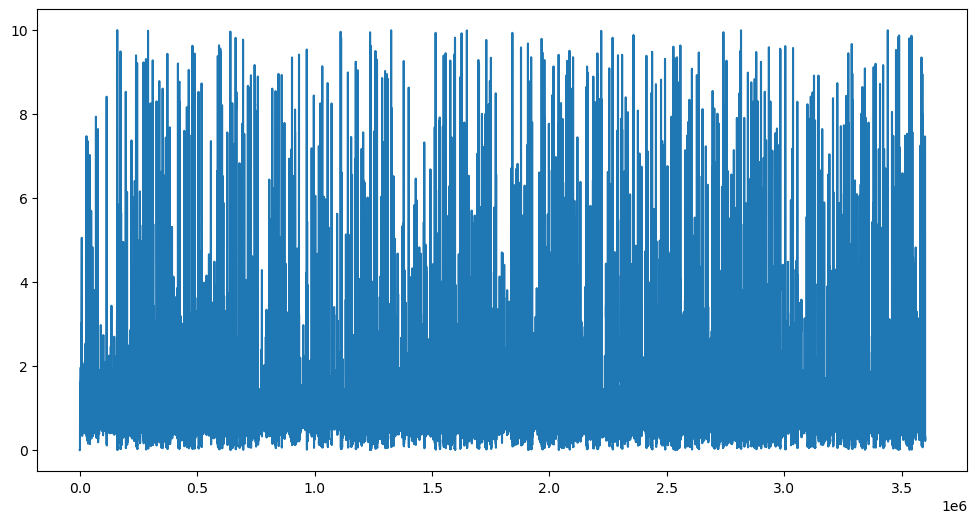

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(cft)
plt.show()

/Users/kaushikpradhan/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


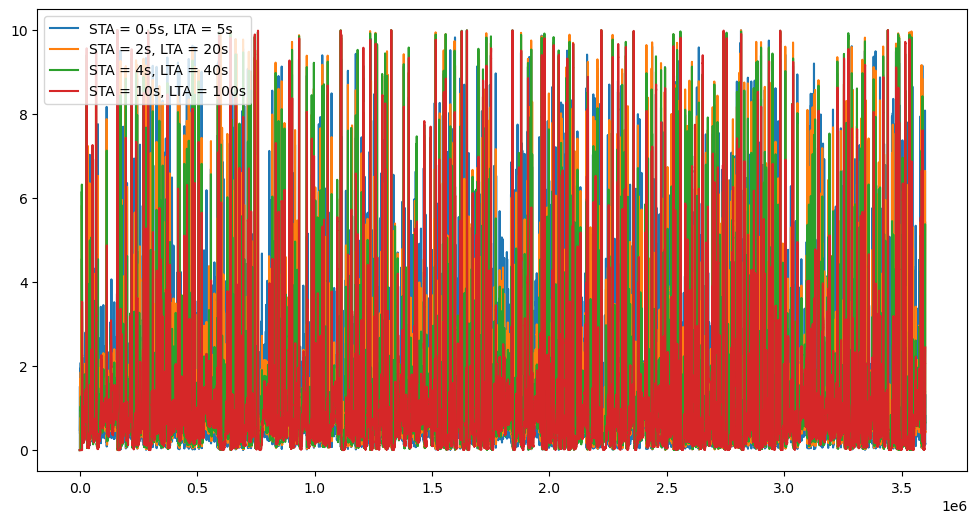

In [ ]:
# vary the sta and lta windows to see the effect on the characteristic function
cft_1 = classic_sta_lta(st[0].data, int(0.5 * st[0].stats.sampling_rate), int(5.0 * st[0].stats.sampling_rate)) 
cft_2 = classic_sta_lta(st[0].data, int(2.0 * st[0].stats.sampling_rate), int(20.0 * st[0].stats.sampling_rate)) 
cft_3 = classic_sta_lta(st[0].data, int(4.0 * st[0].stats.sampling_rate), int(40.0 * st[0].stats.sampling_rate)) 
cft_4 = classic_sta_lta(st[0].data, int(10.0 * st[0].stats.sampling_rate), int(100.0 * st[0].stats.sampling_rate)) 

# plot them all
plt.figure(figsize=(12, 6))
plt.plot(cft_1, label='STA = 0.5s, LTA = 5s')
plt.plot(cft_2, label='STA = 2s, LTA = 20s')
plt.plot(cft_3, label='STA = 4s, LTA = 40s')
plt.plot(cft_4, label='STA = 10s, LTA = 100s')
plt.legend()
plt.show()

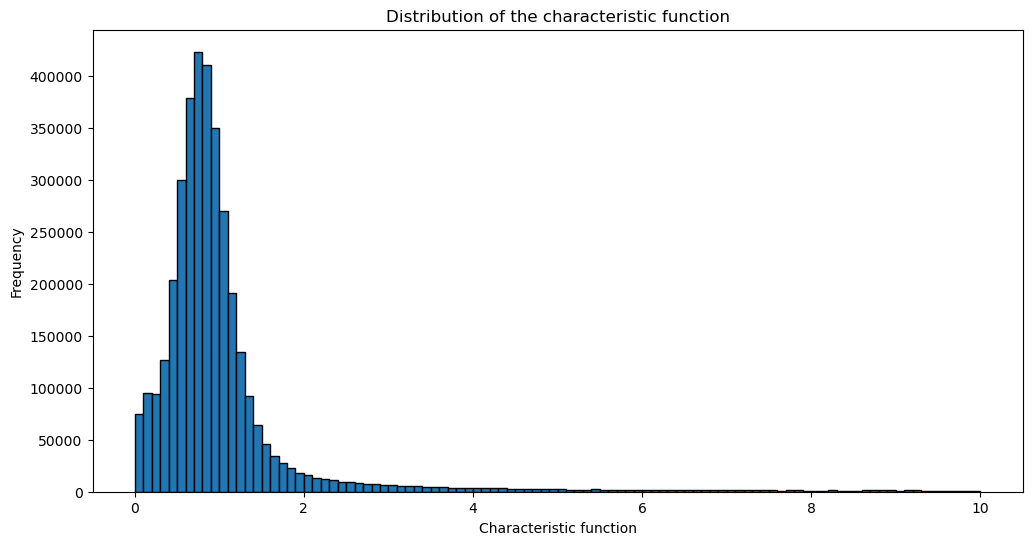

In [ ]:
# put the distribution of the characteristic function in a histogram
plt.figure(figsize=(12, 6))
plt.hist(cft, bins=100, edgecolor='black')
plt.xlabel('Characteristic function')
plt.ylabel('Frequency')
plt.title('Distribution of the characteristic function')
plt.show()

In [ ]:
# keep thresold 1.5 to see the number of events detected
threshold = 5.0
new_cft = cft.copy() 
new_cft[new_cft < threshold] = 0

#count the non zero values
len(new_cft[new_cft > 0])

69139

In [ ]:
# now need to divide the signal into before and after and see the count
st_data_pre_eq = st[0].data[0:len(st[0].data)//2]
st_data_post_eq = st[0].data[len(st[0].data)//2:]

count_event_pre_cft = classic_sta_lta(st_data_pre_eq, int(1.0 * st[0].stats.sampling_rate), int(10.0 * st[0].stats.sampling_rate))
count_event_post_cft = classic_sta_lta(st_data_post_eq, int(1.0 * st[0].stats.sampling_rate), int(10.0 * st[0].stats.sampling_rate))

threshold = 5.0
new_cft_1 = count_event_pre_cft.copy() 
new_cft_1[new_cft_1 < threshold] = 0
count_event_pre = len(new_cft_1[new_cft_1 > 0])

new_cft_2 = count_event_post_cft.copy()
new_cft_2[new_cft_2 < threshold] = 0
count_event_post = len(new_cft_2[new_cft_2 > 0])

print('the number of events before the earthquake is:', count_event_pre)
print('the number of events after the earthquake is:', count_event_post)

the number of events before the earthquake is: 29001
the number of events after the earthquake is: 40138


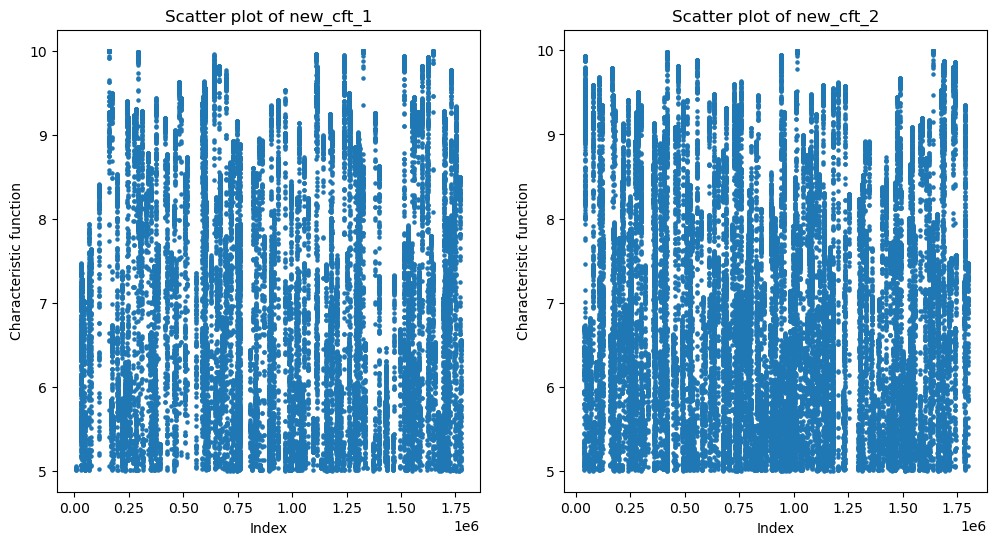

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

non_zero_indices_1 = np.nonzero(new_cft_1)
non_zero_values_1 = new_cft_1[non_zero_indices_1]
ax1.scatter(non_zero_indices_1, non_zero_values_1, s=5)
ax1.set_xlabel('Index')
ax1.set_ylabel('Characteristic function')
ax1.set_title('Scatter plot of new_cft_1')

non_zero_indices_2 = np.nonzero(new_cft_2)
non_zero_values_2 = new_cft_2[non_zero_indices_2]
ax2.scatter(non_zero_indices_2, non_zero_values_2, s=5)
ax2.set_xlabel('Index')
ax2.set_ylabel('Characteristic function')
ax2.set_title('Scatter plot of new_cft_2')

plt.show()

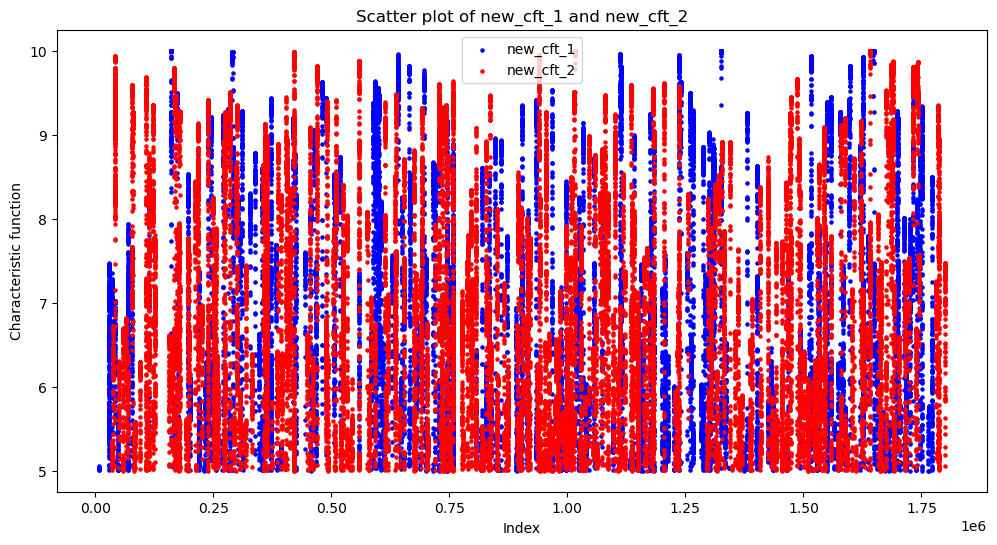

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

non_zero_indices_1 = np.nonzero(new_cft_1)
non_zero_values_1 = new_cft_1[non_zero_indices_1]
ax.scatter(non_zero_indices_1, non_zero_values_1, s=5, c='blue', label='new_cft_1')

non_zero_indices_2 = np.nonzero(new_cft_2)
non_zero_values_2 = new_cft_2[non_zero_indices_2]
ax.scatter(non_zero_indices_2, non_zero_values_2, s=5, c='red', label='new_cft_2')

ax.set_xlabel('Index')
ax.set_ylabel('Characteristic function')
ax.set_title('Scatter plot of new_cft_1 and new_cft_2')
ax.legend()

plt.show()

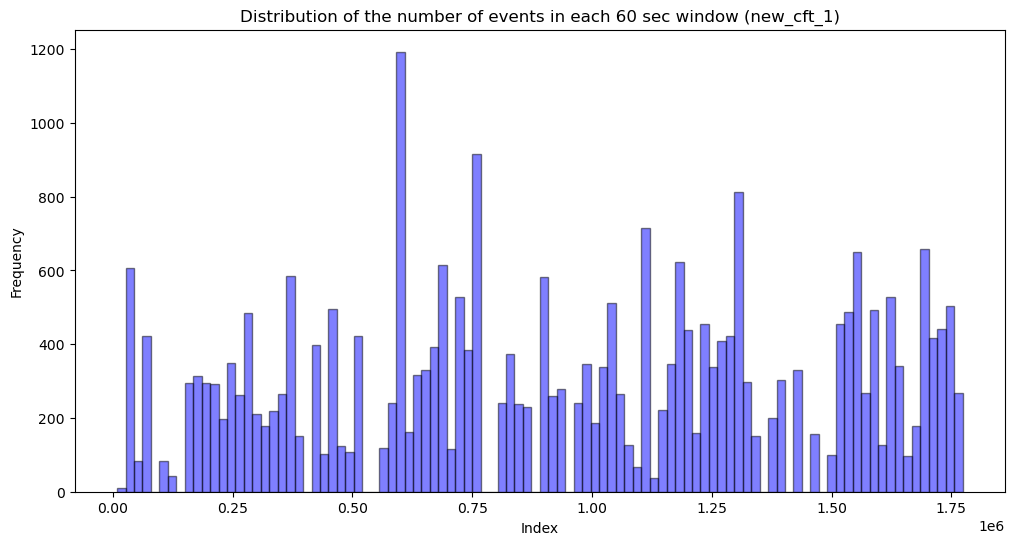

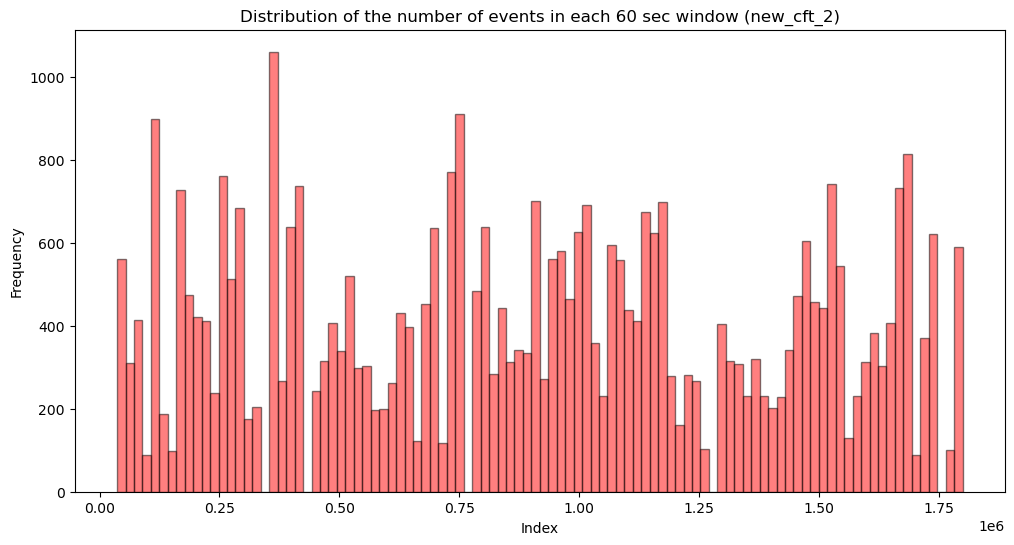

In [ ]:
# Plot for new_cft_1
plt.figure(figsize=(12, 6))
plt.hist(non_zero_indices_1, bins=100, edgecolor='black', color='blue', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Distribution of the number of events in each 60 sec window (new_cft_1)')
plt.show()

# Plot for new_cft_2
plt.figure(figsize=(12, 6))
plt.hist(non_zero_indices_2, bins=100, edgecolor='black', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Distribution of the number of events in each 60 sec window (new_cft_2)')
plt.show()

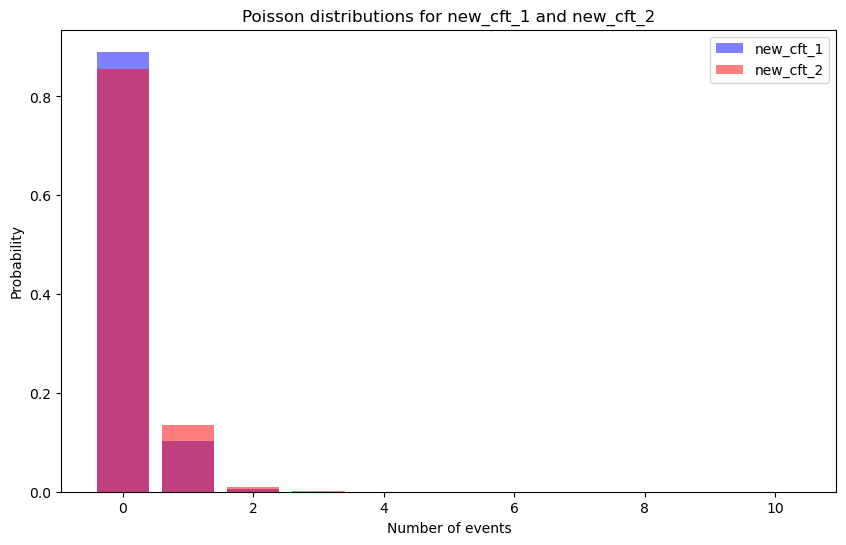

In [ ]:
mu_1 = np.mean(new_cft_1)
mu_2 = np.mean(new_cft_2)
x = np.arange(0, max(max(new_cft_1), max(new_cft_2)) + 1)

# Calculate the Poisson probability mass function for both datasets
poisson_1 = poisson.pmf(x, mu_1)
poisson_2 = poisson.pmf(x, mu_2)

# Plot the Poisson distributions for new_cft_1 and new_cft_2
plt.figure(figsize=(10, 6))
plt.bar(x, poisson_1, color='blue', alpha=0.5, label='new_cft_1')
plt.bar(x, poisson_2, color='red', alpha=0.5, label='new_cft_2')
plt.xlabel('Number of events')
plt.ylabel('Probability')
plt.title('Poisson distributions for new_cft_1 and new_cft_2')
plt.legend()
plt.show()